In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import open_clip
import matplotlib.pyplot as plt
from PIL import Image
import nltk

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.corpus import wordnet

sys.path.append(os.path.abspath("../unlearning"))
from decorrelate_leace import decorrelate, erase_by_ablation, LEACE

# Ensure you have downloaded the WordNet data
nltk.download('wordnet', quiet=True)

/Users/rodrigocruz/Documents/Python_VE/ConceptErasure/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
# -------------------------------
# 1. Define image transformations
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # (Optional) add normalization here if needed by CLIP
])

# -------------------------------
# 2. Load the COCO val2017 dataset
# -------------------------------
images_dir = '/Users/rodrigocruz/coco/images/val2017'  # directory for val images
annotations_file = '/Users/rodrigocruz/coco/annotations/instances_val2017.json'
coco_dataset = datasets.CocoDetection(root=images_dir,
                                      annFile=annotations_file,
                                      transform=transform)

# -------------------------------
# 3. Filter images by concept
# -------------------------------
# Define a helper to check if an image's annotations include the target concept.
def has_category(annotations, category_id):
    return any(ann['category_id'] == category_id for ann in annotations)

# For this example, we'll use the "person" category (COCO category_id = 1)
concept_category_id = 1

images_with_concept = []
images_without_concept = []
for img, anns in coco_dataset:
    if has_category(anns, concept_category_id):
        images_with_concept.append((img, anns))
    else:
        images_without_concept.append((img, anns))

# Create a balanced dataset: equal numbers with and without the concept
n_samples = min(len(images_with_concept), len(images_without_concept))
selected_data = images_with_concept[:n_samples] + images_without_concept[:n_samples]
# Labels: 1 if the concept is present, 0 otherwise.
labels = np.array([1] * n_samples + [0] * n_samples)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


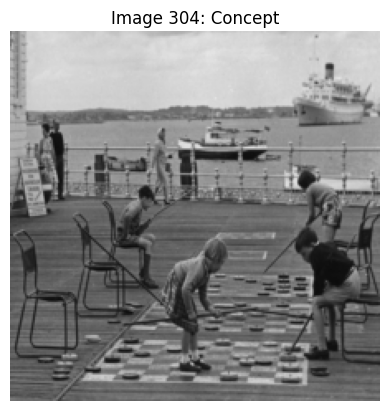

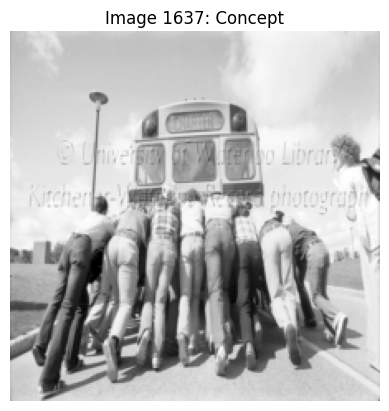

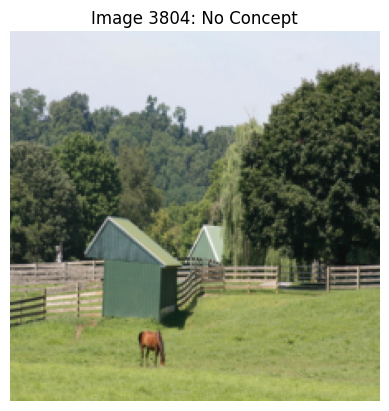

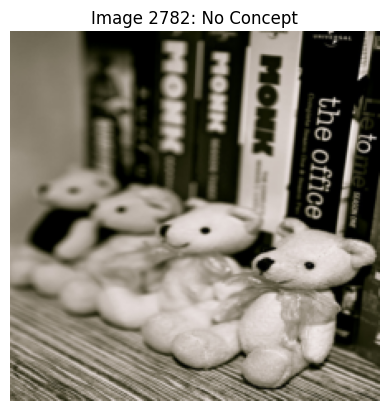

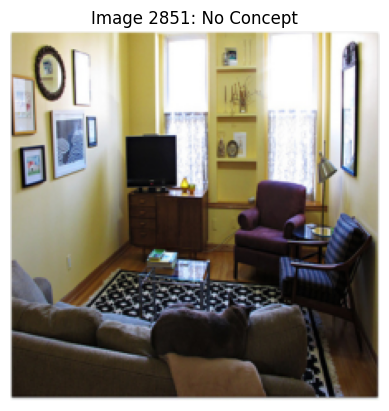

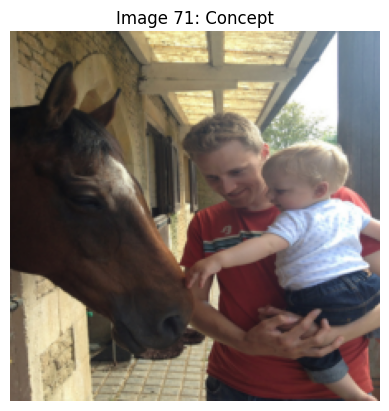

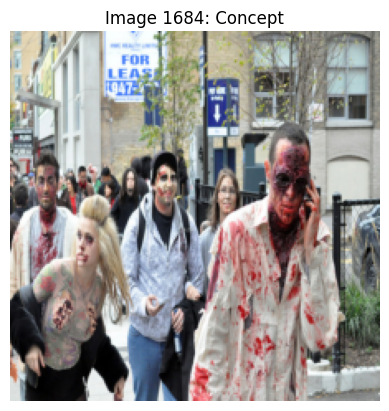

In [4]:
# -------------------------------
# 4. Visualize some images
# -------------------------------

# Create a converter to turn a tensor image into a PIL image if needed.
to_pil = ToPILImage()

# Display the first 5 images from your selected data.
for i in np.random.randint(2*n_samples, size = 7):
    img, anns = selected_data[i]
    # If the image is a tensor, convert it to a PIL image.
    if isinstance(img, torch.Tensor):
        img = to_pil(img)
    
    # Create a title based on the label (assuming 1 means concept present, 0 means absent).
    label = "Concept" if labels[i] == 1 else "No Concept"
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image {i+1}: {label}")
    plt.axis('off')
    plt.show()

In [5]:
# -------------------------------
# 5. Compute CLIP embeddings
# -------------------------------
# Load the open_clip model and its preprocessing transform
device = "mps"  
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", 
    pretrained="laion2B_s34b_B79K", 
    device=device
)

def get_clip_embedding(pil_img):
    """
    Compute the CLIP embedding for a PIL image.
    """
    # Use CLIP's preprocessing to convert the image to the right format.
    image_input = clip_preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = clip_model.encode_image(image_input)
    return embedding.cpu().numpy().flatten()

def tensor_to_pil(tensor_img):
    """
    Convert a tensor image (from torchvision transforms) back to a PIL image.
    """
    tensor_img = tensor_img.cpu().clone().detach()
    tensor_img = tensor_img.squeeze(0)
    return transforms.ToPILImage()(tensor_img)

# Compute embeddings for every image in the selected dataset.
X_list = []
for img, _ in selected_data:
    # Our dataset transform returns a tensor, so convert it to PIL.
    pil_img = tensor_to_pil(img) if isinstance(img, torch.Tensor) else img
    emb = get_clip_embedding(pil_img)
    X_list.append(emb)
clip_embeddings = np.vstack(X_list)  # Final embeddings array with shape (num_samples, embedding_dim)"

surfing: 0.12334416061639786
surfers: 0.09417232125997543
promo: 0.038367971777915955
instructor: 0.025435209274291992
benefits: 0.010070621967315674
surf: 0.0046033114194869995
meets: 0.0035739541053771973
compatible: 0.0013033300638198853
ocean: 0.0003094971179962158
floppy: 0.0


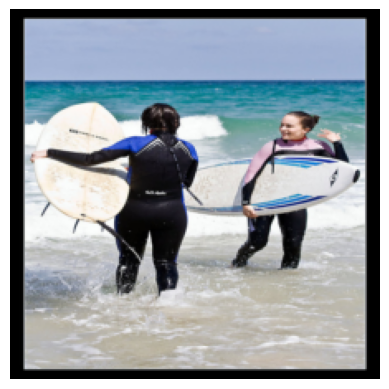

In [ ]:
# -------------------------------
# 6. Load SpLiCE
# -------------------------------
import splice # Ensure you have SpLiCE installed in your environment!
splicemodel = splice.load("open_clip:ViT-B-32", vocabulary="laion", vocabulary_size=10000, return_weights=True, l1_penalty=0.25, device=device)
preprocess = splice.get_preprocess("open_clip:ViT-B-32")
vocabulary = splice.get_vocabulary("laion", 10000) 

# Inspect learned sparse representations
ix = 800 # choose image index
img, anns = selected_data[ix] # select image

plt.imshow(to_pil(img)) # show image
plt.axis('off')

image = preprocess(to_pil(img)).unsqueeze(0).to(device) # preprocess image to feed to splice
sparse_weights = splicemodel.encode_image(image) # get sparse_weights for image
sparse_weights = sparse_weights.squeeze() 

# Print top 10 sparse weights (dictionary entries)
for weight_idx in torch.sort(sparse_weights, descending=True)[1][0:10]: 
    print(f"{vocabulary[weight_idx]}: {sparse_weights[weight_idx]}")


In [ ]:
# -------------------------------
# 7. Apply the concept removal pipeline
# -------------------------------
def get_erased_clip_embedding(images, Y, erasure_method, concept_to_erase=None, vocabulary=None):
    """
    Processes a list of images, computing the SpLiCE embedding for each,
    then erases the specified concept across the dataset (using the provided labels Y if using
    the "decorrelate" method or a concept string for "ablation"), and finally recomposes a 
    modified CLIP embedding for each image.
    
    Parameters:
    -----------
    images : list
        A list of image tuples (img, annotations) from your dataset.
    Y : np.ndarray or torch.Tensor
        Auxiliary variable used for decorrelation (if using the "decorrelate" method).
        For ablation, this parameter is ignored.
    erasure_method : str
        Erasure method to use. Options: "decorrelate" or "ablation" or "LEACE".
    concept_to_erase : str, optional
        The concept to erase (required if erasure_method == "ablation").
    vocabulary : list, optional
        The vocabulary tokens corresponding to the SpLiCE weights 
        (required if erasure_method == "ablation").
    
    Returns:
    --------
    erased_embeddings_np : np.ndarray
        A NumPy array of recomposed (erased) CLIP embeddings for each image,
        with shape (n_samples, 512).
    """
    # First, collect the SpLiCE embeddings for all images.
    splice_embeddings = []
    for img, _ in images:
        # Convert to PIL if needed
        pil_img = img if isinstance(img, Image.Image) else ToPILImage()(img)
        proc_img = preprocess(pil_img).unsqueeze(0).to(device)  # shape: [1, C, H, W]
        emb = splicemodel.encode_image(proc_img)  # Expected shape: [1, vocab_size]
        splice_embeddings.append(emb)
    splice_embeddings = torch.cat(splice_embeddings, dim=0)  # shape: (n_samples, vocab_size)
    
    # Erase the desired concept from the entire set of SpLiCE embeddings.
    if erasure_method == "decorrelate":
        # Ensure Y is a torch tensor with shape (n_samples, d_y). If Y is 1D, reshape it to (n_samples, 1).
        if not torch.is_tensor(Y):
            Y_tensor = torch.tensor(Y, dtype=torch.float32)
        else:
            Y_tensor = Y.float()
        if Y_tensor.dim() == 1:
            Y_tensor = Y_tensor.unsqueeze(1)
        
        # Convert the splice embeddings and Y to NumPy arrays for decorrelation.
        X_np = splice_embeddings.cpu().detach().numpy()
        Y_np = Y_tensor.cpu().detach().numpy()
        
        # Decorrelate X_np with respect to Y_np.
        erased_np = decorrelate(X_np, Y_np)  # Returns an array of shape (n_samples, vocab_size)
        # Convert back to a torch tensor.
        erased_splice = torch.tensor(erased_np, dtype=torch.float32).to(device)
        
    elif erasure_method == "ablation":
        # For ablation, process each splice embedding individually.
        erased_list = []
        for i in range(splice_embeddings.shape[0]):
            emb = splice_embeddings[i]
            # erase_by_ablation returns an erased embedding (same shape as emb)
            erased_emb = erase_by_ablation(emb, concept_to_erase, vocabulary)
            # Ensure the erased_emb has the same shape as emb (add batch dimension if needed)
            erased_list.append(erased_emb.unsqueeze(0))
        erased_splice = torch.cat(erased_list, dim=0)

    elif erasure_method == "LEACE":
        eraser = LEACE()
        # Ensure Y is a torch tensor with shape (n_samples, d_y). If Y is 1D, reshape it to (n_samples, 1).
        if not torch.is_tensor(Y):
            Y_tensor = torch.tensor(Y, dtype=torch.float32)
        else:
            Y_tensor = Y.float()
        if Y_tensor.dim() == 1:
            Y_tensor = Y_tensor.unsqueeze(1)
        
        # Convert the splice embeddings and Y to NumPy arrays for LEACE
        X_np = splice_embeddings.cpu().detach().numpy()
        Y_np = Y_tensor.cpu().detach().numpy()
        
        # Decorrelate X_np with respect to Y_np.
        erased_np = eraser.fit_transform(X_np, Y_np)  # Returns an array of shape (n_samples, vocab_size)
        # Convert back to a torch tensor.
        erased_splice = torch.tensor(erased_np, dtype=torch.float32).to(device)
    else:
        raise ValueError("Unknown erasure_method. Choose 'decorrelate' or 'ablation' or 'LEACE'.")
    
    # Recompose the erased SpLiCE embeddings into the CLIP embedding space.
    clip_embeddings_erased = splicemodel.recompose_image(erased_splice)  # Expected shape: (n_samples, 512)
    
    # Convert to NumPy array.
    erased_embeddings_np = clip_embeddings_erased.cpu().detach().numpy()
    return erased_embeddings_np

In [11]:
# -------------------------------
# 8. Train classifiers to evaluate concept removal
# -------------------------------
# Functions to train and evaluate classifiers.

def evaluate_erasure(selected_data, labels, method):
    if method == "ablation":
        clip_erased = get_erased_clip_embedding(images = selected_data, 
                                                Y = labels, erasure_method = "ablation", 
                                                concept_to_erase = "person", 
                                                vocabulary = splice.get_vocabulary('laion', 10000))
    else: 
        clip_erased = get_erased_clip_embedding(images = selected_data, Y = labels, erasure_method = method)

    def train_logistic_regression(X_data, labels):
        X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.2, random_state=42)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        return accuracy_score(y_test, y_pred)

    class OneLayerMLP(nn.Module):
        def __init__(self, input_dim, num_classes):
            super(OneLayerMLP, self).__init__()
            self.fc = nn.Linear(input_dim, num_classes)
        def forward(self, x):
            return self.fc(x)

    def train_mlp(model, X_data, y, epochs=20, batch_size=32, test_size=0.2, random_state=42):
        # Split data into training and test sets.
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=test_size, random_state=random_state, shuffle=True
        )
        
        # Create training dataset and loader.
        train_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        model.train()
        for epoch in range(epochs):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        # Evaluate on the test set.
        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(X_test, dtype=torch.float32)
            outputs = model(test_inputs)
            _, predicted = torch.max(outputs, 1)
        
        accuracy = (predicted.numpy() == y_test).mean()
        return accuracy
    
    # Train logistic regression on the original clip embeddings
    acc_original = train_logistic_regression(clip_embeddings, labels)
    # Train logistic regression on the erased clip embeddings
    acc_erased = train_logistic_regression(clip_erased, labels)
    print("ERASURE METHOD IS", method)
    print("Logistic Regression accuracy on original embeddings: {:.2f}%".format(acc_original * 100))
    print("Logistic Regression accuracy on erased embeddings: {:.2f}%".format(acc_erased * 100))

    input_dim = clip_embeddings.shape[1]
    num_classes = 2

    # Define one-layer MLP to use on original clip embeddings
    model_orig = OneLayerMLP(input_dim, num_classes)
    # Define one-layer MLP to use on erased clip embeddings
    model_erased = OneLayerMLP(input_dim, num_classes)
    # Train both models and save accuracy
    acc_mlp_orig = train_mlp(model_orig, clip_embeddings, labels)
    acc_mlp_erased = train_mlp(model_erased, clip_erased, labels)
    print("1-Layer MLP accuracy on original embeddings: {:.2f}%".format(acc_mlp_orig * 100))
    print("1-Layer MLP accuracy on erased embeddings: {:.2f}%".format(acc_mlp_erased * 100))
    # Define a two-layer MLP
    class TwoLayerMLP(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_classes):
            super(TwoLayerMLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

    hidden_dim = 128 # Hidden dimension for two-layer MLP    

    # Define two-layer MLPs to use on original and erased clip embeddings
    two_layer_model_orig = TwoLayerMLP(input_dim, hidden_dim, num_classes)
    two_layer_model_erased = TwoLayerMLP(input_dim, hidden_dim, num_classes) 

    # Train both models and save accuracy 
    acc_two_mlp_orig = train_mlp(two_layer_model_orig, clip_embeddings, labels)
    acc_two_mlp_erased = train_mlp(two_layer_model_erased, clip_erased, labels)

    print("2-Layer MLP accuracy on original embeddings: {:.2f}%".format(acc_two_mlp_orig * 100))
    print("2-Layer MLP accuracy on erased embeddings: {:.2f}%".format(acc_two_mlp_erased * 100))

In [14]:
evaluate_erasure(selected_data, labels, "decorrelate") # when using LEACE, SVD does not converge!

ERASURE METHOD IS decorrelate
Logistic Regression accuracy on original embeddings: 91.44%
Logistic Regression accuracy on erased embeddings: 41.93%
1-Layer MLP accuracy on original embeddings: 91.87%
1-Layer MLP accuracy on erased embeddings: 45.18%
2-Layer MLP accuracy on original embeddings: 91.77%
2-Layer MLP accuracy on erased embeddings: 99.67%
